# Generate and Store Dataset

In [1]:
from BasicDataProcessing.generate_train_labels import list_audios
from BasicDataProcessing.generate_spectrograms import *
import numpy as np

In [2]:
audio_list = list_audios("../voxceleb1/vox1_dev_partaa/")
audio_list_test = list_audios("../voxceleb1/test/")

## Spectrograms specs

In [3]:
#Set the spectrograms specifications here and choose the type (log-mel or log-mel-normalized) 
#by running or  not the next sections
audio_ms = 3000 #Length of the audios in milliseconds
sampling_rate = 16000
n_mels = 64
window_ms = 20
stride_ms = 10
normalize = True
base_str = "melSpecSr"+str(audio_ms)+"ms"+str(sampling_rate)+"Hz"+str(n_mels)+"mels"+str(window_ms)+"wd"+str(stride_ms)+"st.bin"
if normalize:
    train_file_pickle = "spectrograms/Norm" + base_str
    test_file_pickle = "spectrograms/NormTest" + base_str 
    scaler_file_pickle = "spectrograms/Scaler" + base_str
else:
    train_file_pickle = "spectrograms/" + base_str
    test_file_pickle = "spectrograms/Test" + base_str 

### Creating new not Normalized spectrograms 

In [4]:
if normalize:
    print("Something is not right! You chose to normalize but this is the not normalized section")
import time
start_time = time.time()

%cd ../voxceleb1/vox1_dev_partaa/
spectrograms = mel_spectrograms(audio_list, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

%cd ../test/
spectrograms_test = mel_spectrograms(audio_list_test, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

print("--- %s seconds ---" % (time.time() - start_time))
print(len(spectrograms))
print(len(spectrograms_test))
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
%cd ../../SpeakerVerificationML/

/Users/zeba/Desktop/speakerVerification/voxceleb1/vox1_dev_partaa


### Creating new Normalized spectrograms

In [4]:
if not normalize:
    print("Something is not right! You chose to not normalize but this is the normalized section")
import time
start_time = time.time()

%cd ../voxceleb1/vox1_dev_partaa/
spectrograms, train_scaler = mel_spectrogramsNormalized(audio_list, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)

%cd ../test/
spectrograms_test = mel_spectrograms(audio_list_test, audio_ms, sampling_rate, n_mels, window_ms, stride_ms)
spectrograms_test = NormalizeDictUsingScaler(spectrograms_test, audio_list_test, train_scaler)

print("--- %s seconds ---" % (time.time() - start_time))
print(len(spectrograms))
print(len(spectrograms_test))
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
%cd ../../SpeakerVerificationML/

/Users/zeba/Desktop/speakerVerification/voxceleb1/vox1_dev_partaa
/Users/zeba/Desktop/speakerVerification/voxceleb1/test
--- 465.04334330558777 seconds ---
48840
4874
/Users/zeba/Desktop/speakerVerification/SpeakerVerificationML


## Dumps spectrograms using pickle

In [5]:
#If hasn't saved the spectrograms in a file
import pickle
start_time = time.time()
    
with open(train_file_pickle, "wb") as myFile:
    pickle.dump(spectrograms, myFile)
    
with open(test_file_pickle, "wb") as myFile:
    pickle.dump(spectrograms_test, myFile)

if normalize:
    with open(scaler_file_pickle, "wb") as myFile:
        pickle.dump(train_scaler, myFile)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 38.605676889419556 seconds ---


## Loading spectrograms

How to load the spectrograms using Pickle (the path might change)

In [7]:
#If only wants to load:
import pickle

with open(train_file_pickle, "rb") as myFile:
    spectrograms = pickle.load(myFile)
    
with open(test_file_pickle, "rb") as myFile:
    spectrograms_test = pickle.load(myFile)

if normalize:
    with open(scaler_file_pickle, "rb") as myFile:
        train_scaler = pickle.load(myFile)

(64, 301)

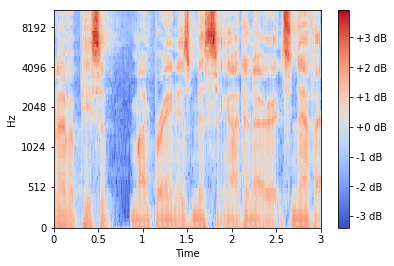

In [10]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms["id10022/ZXYlWu1JfKU/00024.wav"], 16000, stride_size)
spectrograms["id10022/ZXYlWu1JfKU/00024.wav"].shape

## Get the dataset labels

In [11]:
train_list_audios_x = []
train_list_y = []
with open("../voxceleb1/veri_train.txt") as train_labels_file:
    for line in train_labels_file:
        splitted = line.split()
        train_list_y.append(splitted[0])
        train_list_audios_x.append([splitted[1],splitted[2]])

train_y = np.zeros((len(train_list_y), 1))

for i in range(len(train_list_y)):
    train_y[i] = train_list_y[i]
    
print(train_y.shape)
print(len(train_list_audios_x))

#Generate test datasets
test_list_audios_x = []
test_list_y = []
with open("../voxceleb1/veri_test.txt") as test_labels_file:
    for line in test_labels_file:
        splitted = line.split()
        test_list_y.append(splitted[0])
        test_list_audios_x.append([splitted[1],splitted[2]])

test_y = np.zeros((len(test_list_y), 1))

for i in range(len(test_list_y)):
    test_y[i] = test_list_y[i]

print(test_y.shape)
print(len(test_list_audios_x))

(311260, 1)
311260
(37720, 1)
37720


In [12]:
train_list_audios_x[311259]

['id11096/5n94z8rkb0U/00005.wav', 'id11096/Zvkwxk-EBVY/00003.wav']

In [13]:
#Generates mini batches using the spectrograms as channels. A pair = 2 channels
def generate_mini_batch(size, index, spectrograms, spec_shape, train_y, train_list_audios_x):
    min_index = index*size
    max_index = len(train_list_audios_x) if (len(train_list_audios_x) <= (index+1)*size) else (index+1)*size
    
    mini_batch_x = np.zeros((max_index - min_index, 2, spec_shape[0], spec_shape[1]))
    mini_batch_y = train_y[min_index : max_index]
    for i in range(min_index, max_index):
        mini_batch_x[i - min_index][0] = spectrograms[train_list_audios_x[i][0]]
        mini_batch_x[i - min_index][1] = spectrograms[train_list_audios_x[i][1]]
        
    return mini_batch_x, mini_batch_y
    

In [14]:
generate_mini_batch(16, 19452, spectrograms, (64, 301), train_y, train_list_audios_x)

(array([[[[-1.00808781e+00, -1.94589348e+00, -1.59299599e+00, ...,
           -2.61515613e+00, -1.98607165e+00, -3.10277786e-01],
          [-1.23138166e+00, -1.33232953e+00, -1.33491074e+00, ...,
           -1.71457023e+00, -1.54093012e+00, -2.97385897e-01],
          [-1.07638414e+00, -1.46061080e+00, -1.48178033e+00, ...,
           -1.50446033e+00, -1.38335448e+00, -1.23863276e-01],
          ...,
          [ 4.46167755e-01, -1.12436039e-01, -3.49055906e-01, ...,
           -1.25881716e-01,  1.01990596e-02, -4.51371264e-01],
          [ 6.33644756e-01,  2.36263738e-02, -2.61307323e-01, ...,
            1.09601586e-01,  9.61068982e-02, -2.15474413e-01],
          [ 6.03808345e-01, -1.20315031e-01, -4.68315139e-01, ...,
           -4.04117875e-01, -6.93971664e-03, -1.75633673e-01]],
 
         [[ 6.93106794e-01, -2.08451809e+00, -1.57964138e+00, ...,
           -1.21576683e+00, -8.66041163e-01, -7.75936042e-01],
          [ 8.00292153e-01,  3.52159123e-01,  2.50688129e-01, ...,
     

Sanity check

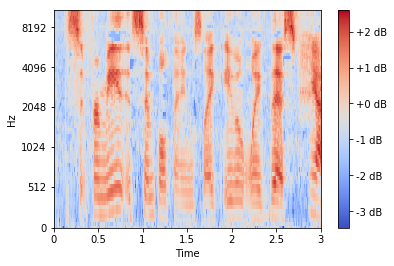

In [17]:
stride_size = int(0.001 * 16000 * 10)
display_spectrogram(spectrograms[train_list_audios_x[0][0]], 16000, stride_size)

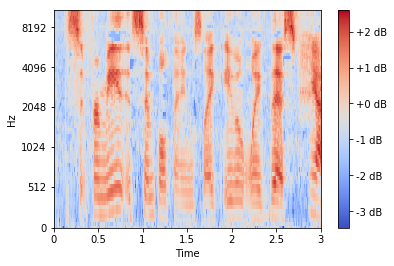

In [18]:
mini_batch_x, mini_batch_y = generate_mini_batch(1, 0, spectrograms, (64, 301), train_y, train_list_audios_x)
display_spectrogram(mini_batch_x[0][0], 16000, stride_size)

# Model Protoypes

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from math import ceil

from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import backend
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

backend.set_floatx('float32')

In [134]:
# Get the model.
inputs = Input(shape=(2, 64, 301), name='spectrograms')
x = Flatten()(inputs)
x = Dense(128, activation='relu', name='dense_1')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='dense_2')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='dense_3')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='dense_4')(x)
outputs = Dense(2, name='predictions')(x)
model = Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = Adam(learning_rate=1e-4)
# Instantiate a loss function.
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [135]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               165

In [136]:
epochs = 30
mini_batch_size = 256
spec_shape = (64, 301)

start_time = time.time()

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    last_index = ceil(len(train_list_audios_x) / mini_batch_size)

    # Iterate over the batches of the dataset.
    for step in range(last_index):
        mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms, spec_shape, train_y, train_list_audios_x)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(mini_batch_x, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(mini_batch_y, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * mini_batch_size))
print("--- %s seconds ---" % (time.time() - start_time))

Start of epoch 0
Training loss (for one batch) at step 0: 0.8450470566749573
Seen so far: 256 samples
Training loss (for one batch) at step 200: 0.6953662633895874
Seen so far: 51456 samples
Training loss (for one batch) at step 400: 0.725624680519104
Seen so far: 102656 samples
Training loss (for one batch) at step 600: 0.6954283714294434
Seen so far: 153856 samples
Training loss (for one batch) at step 800: 0.7303262948989868
Seen so far: 205056 samples
Training loss (for one batch) at step 1000: 0.6851470470428467
Seen so far: 256256 samples
Training loss (for one batch) at step 1200: 0.6939985752105713
Seen so far: 307456 samples
Start of epoch 1
Training loss (for one batch) at step 0: 0.6670254468917847
Seen so far: 256 samples
Training loss (for one batch) at step 200: 0.6490499973297119
Seen so far: 51456 samples
Training loss (for one batch) at step 400: 0.6696357727050781
Seen so far: 102656 samples
Training loss (for one batch) at step 600: 0.6347475051879883
Seen so far: 15

Training loss (for one batch) at step 1200: 0.3814176917076111
Seen so far: 307456 samples
Start of epoch 13
Training loss (for one batch) at step 0: 0.430222749710083
Seen so far: 256 samples
Training loss (for one batch) at step 200: 0.442979633808136
Seen so far: 51456 samples
Training loss (for one batch) at step 400: 0.4337233006954193
Seen so far: 102656 samples
Training loss (for one batch) at step 600: 0.48388320207595825
Seen so far: 153856 samples
Training loss (for one batch) at step 800: 0.4930242598056793
Seen so far: 205056 samples
Training loss (for one batch) at step 1000: 0.38411104679107666
Seen so far: 256256 samples
Training loss (for one batch) at step 1200: 0.39019471406936646
Seen so far: 307456 samples
Start of epoch 14
Training loss (for one batch) at step 0: 0.41659194231033325
Seen so far: 256 samples
Training loss (for one batch) at step 200: 0.39772430062294006
Seen so far: 51456 samples
Training loss (for one batch) at step 400: 0.3985726237297058
Seen so 

Training loss (for one batch) at step 800: 0.3953975439071655
Seen so far: 205056 samples
Training loss (for one batch) at step 1000: 0.299517959356308
Seen so far: 256256 samples
Training loss (for one batch) at step 1200: 0.2698806822299957
Seen so far: 307456 samples
Start of epoch 26
Training loss (for one batch) at step 0: 0.2912029027938843
Seen so far: 256 samples
Training loss (for one batch) at step 200: 0.2946407198905945
Seen so far: 51456 samples
Training loss (for one batch) at step 400: 0.3095661997795105
Seen so far: 102656 samples
Training loss (for one batch) at step 600: 0.3025929629802704
Seen so far: 153856 samples
Training loss (for one batch) at step 800: 0.32589948177337646
Seen so far: 205056 samples
Training loss (for one batch) at step 1000: 0.32334643602371216
Seen so far: 256256 samples
Training loss (for one batch) at step 1200: 0.29366862773895264
Seen so far: 307456 samples
Start of epoch 27
Training loss (for one batch) at step 0: 0.2692950665950775
Seen

In [23]:
#Evaluates on a dataset using SparseCategoricalAccuracy
def evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, test_y, test_list_audios_x, spectrograms):
    test_acc_metric = SparseCategoricalAccuracy()

    last_index = ceil(len(test_list_audios_x) / mini_batch_size)

    # Iterate over the batches of the dataset.
    for step in range(last_index):
        mini_batch_x, mini_batch_y = generate_mini_batch(mini_batch_size, step, spectrograms, spec_shape, test_y, test_list_audios_x)
        test_logits = model(mini_batch_x)
        # Update val metrics
        test_acc_metric(mini_batch_y, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    return float(test_acc)

In [137]:
#Test set
mini_batch_size = 512
evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, test_y, test_list_audios_x, spectrograms_test)

0.698886513710022

In [138]:
#Train set
mini_batch_size = 512
evaluate_mini_batches_SparCateAccuracy(model, mini_batch_size, spec_shape, train_y, train_list_audios_x, spectrograms)

0.9250530004501343

### Accuracy of sanity check models
#### Model: "model_1"
Dataset = Normalized
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       
Total params: 4,931,970
Trainable params: 4,931,970
Non-trainable params: 0

optimizer = Adam(learning_rate=1e-5)
mini_batch_size = 512

Minimum error on last batch of last epoch: 0.44655171036720276

6 epochs : 
Train dataset: 0.7922829985618591
Test dataset: 0.6695122122764587

#### Model: "model_2"
Same as model_1 but:
optimizer = Adam(learning_rate=1e-4)


Minimum error on last batch of last epoch: 0.3574866056442261

6 epochs : 
Train dataset: 0.8280569314956665
Test dataset: 0.6800106167793274

#### Model: "model_3"
Same as model_2 but:
mini_batch_size = 128


Minimum error on last batch of last epoch: 0.4185640811920166

6 epochs : 
Train dataset: 0.8206194043159485
Test dataset: 0.6824496388435364

#### Model: "model_4"
Same as model_1 but:
optimizer = Adam(learning_rate=1e-3)


Minimum error on last batch of last epoch: 0.44768232107162476

6 epochs : 
Train dataset: 0.7769774198532104 
Test dataset: 0.6722428202629089

#### Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               9863424   
_________________________________________________________________
predictions (Dense)          (None, 2)                 514       

Total params: 9,863,938
Trainable params: 9,863,938
Non-trainable params: 0

optimizer = Adam(learning_rate=1e-4)
mini_batch_size = 512

Minimum error on last batch of last epoch: 0.3708435297012329

6 epochs : 
Train dataset: 0.8209856748580933
Test dataset: 0.6622481346130371

12 Epochs:
Train dataset: 0.8486731052398682
Test dataset: 0.6575026512145996

#### Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               30823200  
_________________________________________________________________
predictions (Dense)          (None, 2)                 1602      

Total params: 30,824,802
Trainable params: 30,824,802
Non-trainable params: 0

optimizer = Adam(learning_rate=1e-4)
mini_batch_size = 512

Minimum error on last batch of last epoch: 0.37115705013275146

10 epochs : 
Train dataset: 0.80972820520401
Test dataset: 0.6347295641899109

Minimum error on last batch of last epoch: 0.3373027443885803
8 epochs :
Train dataset: 0.836895227432251
Test dataset: 0.6469777226448059

#### Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       

Total params: 4,948,482
Trainable params: 4,948,482
Non-trainable params: 0

optimizer = Adam(learning_rate=1e-4)
mini_batch_size = 512

Minimum error on last batch of last epoch: 0.3068089485168457
8 epochs :
Train dataset: 0.848702073097229
Test dataset: 0.6727730631828308
_________________________________________________________________
_________________________________________________________________

#### Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       

Total params: 4,964,994
Trainable params: 4,964,994
Non-trainable params: 0

10 epochs

train  0.9023002982139587
test 0.6711028814315796

#### Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       
Total params: 4,981,506
Trainable params: 4,981,506
Non-trainable params: 0
_________________________

16 epochs
Minimum error on last batch of last epoch: 0.08534012734889984
train 0.9169697165489197
test 0.6724019050598145

### Using dropout and measuring time
#### Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       

Total params: 4,981,506
Trainable params: 4,981,506
Non-trainable params: 0

optimizer = Adam(learning_rate=1e-4)
mini_batch_size = 512

20 epochs : 
Minimum error on last batch of last epoch: 0.3608514070510864
Train dataset: 0.8803829550743103
Test dataset: 0.7081654071807861
Time = 2662.7750980854034 seconds

mini_batch_size = 256
10 epochs:
Minimum error on last batch of last epoch: 0.44178885221481323
Train dataset: 0.8035051226615906
Test dataset: 0.7016171813011169
Time = 1316.36377120018 seconds

30 epochs:
Minimum error on last batch of last epoch: 0.27...
Train dataset: 0.9250530004501343
Test dataset: 0.698886513710022
Time = 5017.327970027924 seconds

mini_batch_size = 64
10 epochs:
Minimum error on last batch of last epoch: 0.38612687587738037 
Train dataset: 0.8199287056922913
Test dataset: 0.7056733965873718
Time =  2144.309693813324 seconds

#### Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

spectrograms (InputLayer)    [(None, 2, 64, 301)]      0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 38528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4931712   
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 2)                 258       

Total params: 5,063,682
Trainable params: 5,063,682
Non-trainable params: 0

mini_batch_size = 256
10 epochs:
Minimum error on last batch of last epoch: 0.3951340317726135
Train dataset: 0.8299749493598938
Test dataset: 0.707343578338623
Time = 1651.1348779201508 seconds